In [2]:
from dask.distributed import Client
from dask.diagnostics import ProgressBar
import numpy as np
import xarray as xr
import pandas as pd
import hvplot.xarray
from matplotlib import widgets
from matplotlib import pyplot as plt
from rasterio import RasterioIOError
from tqdm.autonotebook import tqdm
%matplotlib inline
import skimage.morphology
import skimage.segmentation
#import richdem as rd
import scipy.ndimage
import dask
import math
import scipy.sparse

from matplotlib import widgets

import dask.array as da

from skimage import data, io

import cartopy.crs as ccrs

import landlab

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # Remove the CWD from sys.path while we load stuff.


In [1]:
conda install landlab

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - landlab


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    black-19.10b0              |             py_4          83 KB  conda-forge
    bmipy-2.0                  |             py_0          11 KB  conda-forge
    landlab-2.1.1              |   py37h03ebfcd_0         2.1 MB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    pathspec-0.8.0             |     pyh9f0ad1d_0          28 KB  conda-forge
    patsy-0.5.1                |             py_0         187 KB  conda-forge
    regex-2020.7.14            |   py37h8f50634_0         352 KB  conda-forge
   

In [3]:
uri_fmt = 'https://storage.googleapis.com/pangeo-pgc/8m/{i_idx:02d}_{j_idx:02d}/{i_idx:02d}_{j_idx:02d}_8m_dem_COG_LZW.tif'

chunksize = 8 * 512
rows = []
for i in tqdm(range(38, 36, -1)): #this tile range is Amery Ice Shelf
    cols = []
    for j in range(47, 53):
        uri = uri_fmt.format(i_idx=i, j_idx=j)
        try:
            dset = xr.open_rasterio(uri, chunks=chunksize)
            dset_masked = dset.where(dset > 0.0)
            cols.append(dset_masked)
            #print(uri)
        except RasterioIOError:
            pass
    rows.append(cols)

In [4]:
dsets_rows = [xr.concat(row, 'x') for row in rows]
ds = xr.concat(dsets_rows, 'y', )
ds.data

,Array,Chunk
Bytes,7.50 GB,67.11 MB
Shape,"(1, 25000, 75000)","(1, 4096, 4096)"
Count,972 Tasks,192 Chunks
Type,float32,numpy.ndarray


In [5]:
ds_array = ds.squeeze()
ds_array.data

dask.array<getitem, shape=(25000, 75000), dtype=float32, chunksize=(4096, 4096), chunktype=numpy.ndarray>

In [6]:
ds_array_rs = ds_array.coarsen(x=40,y=40).mean()


In [7]:
from landlab import RasterModelGrid


In [8]:
with ProgressBar():
    dem  = ds_array_rs.values


[###                                     ] | 8% Completed |  1min 23.7s

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[##########                              ] | 26% Completed |  3min 30.2s

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 12min 18.9s


dem[0:-1,0]  = np.nan
dem[0:-1,-1] = np.nan
dem[0,0:-1] = np.nan
dem[-1,0:-1] = np.nan

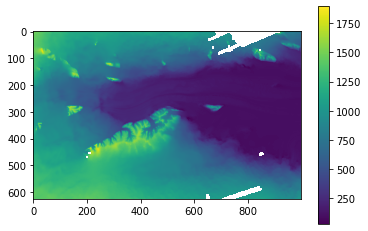

In [9]:
plt.imshow(dem[:,0:1000])
plt.colorbar()

In [10]:
dem = dem[:,0:1000]

In [11]:
mg = RasterModelGrid(dem.shape)

In [12]:
z = mg.add_field("topographic__elevation", np.float_(dem.ravel()), at="node", units="m", copy=True, clobber=False)
mg.set_status_at_node_on_edges(right=mg.BC_NODE_IS_FIXED_VALUE,
                               top=mg.BC_NODE_IS_CLOSED,
                               left=mg.BC_NODE_IS_FIXED_GRADIENT,
                               bottom=mg.BC_NODE_IS_CLOSED)

In [13]:
from landlab.utils import watershed
from landlab.components import FlowAccumulator, DepressionFinderAndRouter
from landlab.plot import imshow_grid

In [14]:
df = DepressionFinderAndRouter(mg, routing='D8',reroute_flow=True)

In [15]:
fa = FlowAccumulator(mg,
                     flow_director='D8',
                     depression_finder= df)


In [17]:
fa.accumulate_flow()

(array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]))

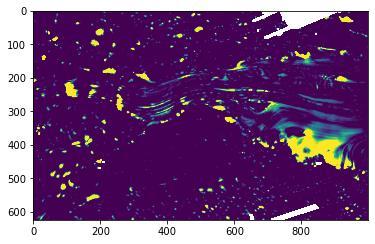

In [18]:
plt.imshow(fa.depression_finder.depression_depth.reshape(dem.shape),vmin=0, vmax=6)

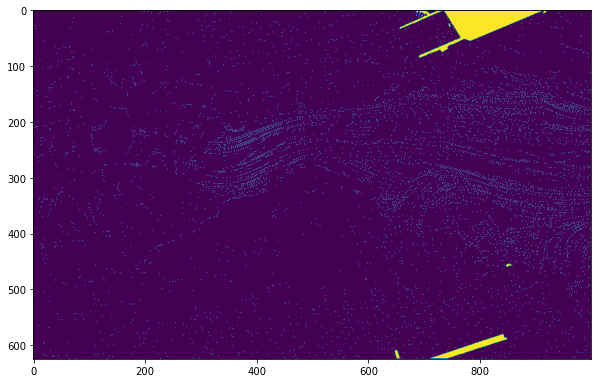

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(fa.depression_finder.is_pit.reshape(dem.shape))


In [20]:
ws = watershed.get_watershed_masks(mg)

In [21]:
#ws = watershed.get_watershed_masks_with_area_threshold(mg,100)

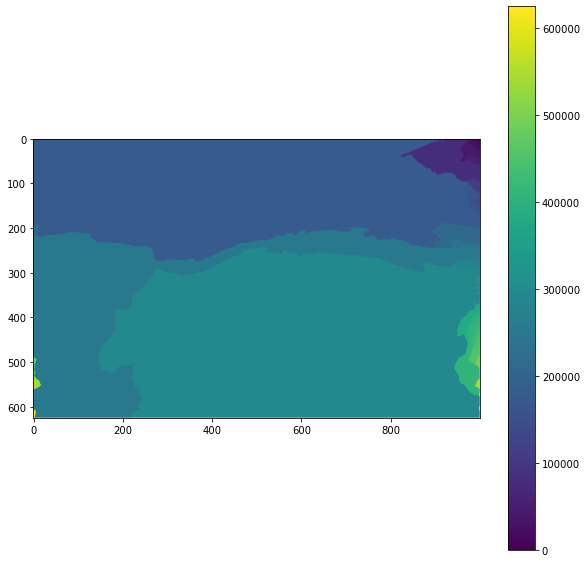

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(ws.reshape(dem.shape))
plt.colorbar()

In [23]:
DB = skimage.morphology.label(ws.reshape(dem.shape),background=0)

In [24]:
histcount = np.bincount(DB.ravel())
main_catchments = np.argwhere(histcount>=100)

In [25]:
main_catchments

array([[1001],
       [1002],
       [1003],
       [1004],
       [1084],
       [1181],
       [1195],
       [1263],
       [1367],
       [1377],
       [1382],
       [1403],
       [1452],
       [1488],
       [1523],
       [1539],
       [1765],
       [1782],
       [1804],
       [1818],
       [1826],
       [1838],
       [1870],
       [1902],
       [1976],
       [1978],
       [2068]])

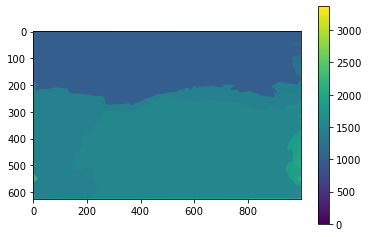

In [26]:
plt.imshow(skimage.morphology.label(DB, connectivity=1))
plt.colorbar()


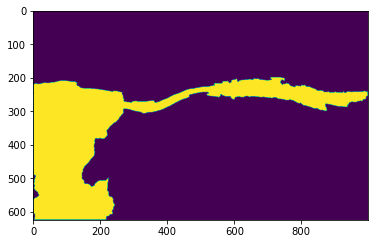

In [27]:
plt.imshow(DB==1403)

In [31]:
mg2 =  mg

fa2 = FlowAccumulator(mg2,
                     flow_director='D8')


fa2.accumulate_flow()

ws_nowater =  watershed.get_watershed_masks(mg2)

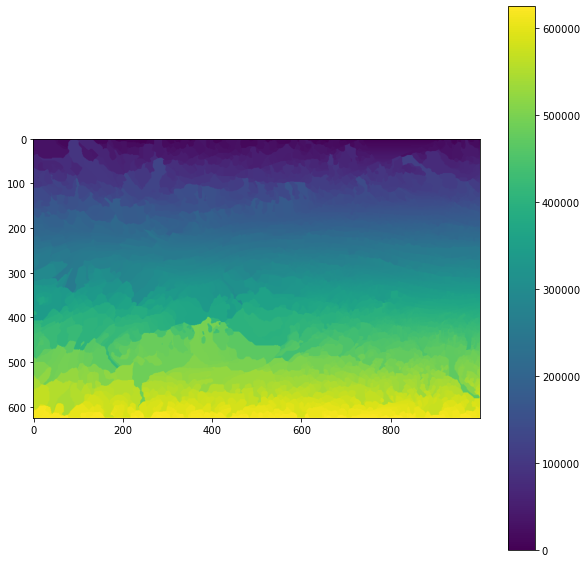

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(ws_nowater.reshape(dem.shape))
plt.colorbar()

In [33]:
DB_nowater = ws_nowater.reshape(dem.shape)

In [42]:
P_all = df.depression_depth.reshape(dem.shape)
cellArea = np.mean(np.float_(ds_array_rs.x[1:-1])-np.float_(ds_array_rs.x[0:-2]))*np.mean(np.float_(ds_array_rs.y[0:-2])-np.float_(ds_array_rs.y[1:-1]))

#Build  data structure  on each drainage Catchments
b_dict = {'SubCatchmentNumbers','SubCatchmentAreas','SubCatchmentVolumes','CatchmentNumber','CatchmentArea','MaskLogical','MaskI','MaskXY','skip','Volume','maxdepth','hw','h'}
b = pd.DataFrame(data={},columns=b_dict)
histcount = np.bincount(DB.ravel())
main_catchments = np.argwhere(histcount>=100)
for kk in main_catchments:
    CatchmentNumber = kk;
    Mask = DB == kk; 
    SubCatchmentNumbers  = np.unique((DB_nowater[Mask]).ravel())
    SubCatchmentNumbers =  SubCatchmentNumbers[1:-1]
    subset = DB_nowater[Mask]
    [SubCatchmentPixelN, bins]=np.histogram(subset, bins=(np.unique(subset)))
    SubCatchmentAreas = SubCatchmentPixelN*cellArea
    counter=0
    SubCatchmentVolumes = np.zeros((len(SubCatchmentNumbers),1))
    for jj in SubCatchmentNumbers:
        SubCatchmentMask =  DB_nowater == jj
        SubCatchmentMaskXY = np.where(SubCatchmentMask)
        SubCatchmentVolumes[counter] = np.sum((P_all[SubCatchmentMaskXY]).ravel()) * cellArea
        counter = counter+1
        
    CatchmentArea = (np.sum(np.int_(Mask.ravel()))*cellArea); # basin area in m^2
    MaskLogical = Mask;
    MaskXY = np.where(Mask);  # mask for the basin
    MaskI= np.ravel_multi_index(MaskXY,dem.shape)
    depths = P_all[MaskXY] #Water accomodation space in drainage basin
    if np.count_nonzero(depths>0)<1: #If accomodation space is demero, i.e, no nondemero depths
        skip = 1;
        h = 0;
        maxdepth = 0;
        Volume = 0;
        hw = np.zeros(depths.size)
        #continue
    else:
        valid = np.argwhere(depths>=0)
        depths = depths[valid];
        heights = np.max(depths) - depths; #potential water height from bottom
        skip = 0;        
        Volume = (np.sum(depths.ravel())*cellArea);
        heights_sorted = np.sort(heights);
        while len(np.argwhere(np.diff(heights_sorted)==0))>0: #remove all identical pixels
            I = np.argwhere(np.diff(heights_sorted)==0);
            heights_sorted[I+1] = heights_sorted[I+1] +0.0001; # nudge the similar values up a tiny amount to avoid issues with the interpolation
        hw = heights_sorted;   # heights for hypsometry
        maxdepth = np.max(depths); # not actually the same as max(Heights) the smallest value of depths is not equal to demero
        h = 0;   # initial water depth is demero
    data={'CatchmentNumber':CatchmentNumber,
           'CatchmentArea':CatchmentArea,
           'MaskLogical':MaskLogical.ravel(),
           'MaskI':MaskI,
            'MaskXY': MaskXY,
           'skip':skip,
           'Volume':Volume,
           'maxdepth':maxdepth,
           'hw':hw,
           'h':h,
            'SubCatchmentNumbers':  SubCatchmentNumbers,
         'SubCatchmentAreas': SubCatchmentAreas,
         'SubCatchmentVolumes': SubCatchmentVolumes}
    DrainageBasin = pd.Series(data)
    b = b.append(DrainageBasin, ignore_index=True)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal


In [143]:
DB = skimage.morphology.label(ws.reshape(dem.shape))
P_all = df.depression_depth.reshape(dem.shape)
cellArea = np.mean(np.float_(ds_array_rs.x[1:-1])-np.float_(ds_array_rs.x[0:-2]))*np.mean(np.float_(ds_array_rs.y[0:-2])-np.float_(ds_array_rs.y[1:-1]))

#Build  data structure  on each drainage basin
b_dict = {'BasinNumber','BasinArea','MaskLogical','MaskI','MaskXY','skip','Volume','maxdepth','hw','h'}
b = pd.DataFrame(data={},columns=b_dict)
num_basins = np.max(DB)
for kk in np.arange(0,num_basins):
    BasinNumber = kk;
    Mask = DB == kk; 
    BasinArea = (np.sum(np.int_(Mask.ravel()))*cellArea); # basin area in m^2
    MaskLogical = Mask;
    MaskXY = np.where(Mask);  # mask for the basin
    MaskI= np.ravel_multi_index(MaskXY,dem.shape)
    depths = P_all[MaskXY] #Water accomodation space in drainage basin
    if np.count_nonzero(depths>0)<1: #If accomodation space is demero, i.e, no nondemero depths
        skip = 1;
        h = 0;
        maxdepth = 0;
        Volume = 0;
        hw = np.zeros(depths.size)
        #continue
    else:
        valid = np.argwhere(depths>=0)
        depths = depths[valid];
        heights = np.max(depths) - depths; #potential water height from bottom
        skip = 0;        
        Volume = (np.sum(depths.ravel())*cellArea);
        heights_sorted = np.sort(heights);
        while len(np.argwhere(np.diff(heights_sorted)==0))>0: #remove all identical pixels
            I = np.argwhere(np.diff(heights_sorted)==0);
            heights_sorted[I+1] = heights_sorted[I+1] +0.0001; # nudge the similar values up a tiny amount to avoid issues with the interpolation
        hw = heights_sorted;   # heights for hypsometry
        maxdepth = np.max(depths); # not actually the same as max(Heights) the smallest value of depths is not equal to demero
        h = 0;   # initial water depth is demero
    data={'BasinNumber':BasinNumber,
           'BasinArea':BasinArea,
           'MaskLogical':MaskLogical.ravel(),
           'MaskI':MaskI,
            'MaskXY': MaskXY,
           'skip':skip,
           'Volume':Volume,
           'maxdepth':maxdepth,
           'hw':hw,
           'h':h}
    DrainageBasin = pd.Series(data)
    b = b.append(DrainageBasin, ignore_index=True)


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater_equal


In [144]:
b

,MaskLogical,Volume,MaskXY,skip,BasinArea,MaskI,BasinNumber,maxdepth,hw,h
0,"[True, True, True, True, True, True, True, Tru...",0,"([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,3.152896e+08,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,"[False, False, False, False, False, False, Fal...",9.85792e+09,"([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0,2.185411e+10,"[1001, 1002, 1003, 1004, 1005, 1006, 1007, 100...",1,119.457,"[[119.457336426], [119.457336426], [119.457336...",0
2,"[False, False, False, False, False, False, Fal...",2.30676e+09,"([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0,8.999936e+08,"[1921, 1922, 1923, 1924, 1925, 1926, 1927, 192...",2,128.34,"[[128.340026855], [128.340026855], [128.340026...",0
3,"[False, False, False, False, False, False, Fal...",31112.5,"([1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5,...",0,1.087488e+08,"[1967, 1968, 2967, 2968, 2969, 3967, 3968, 396...",3,0.303833,"[[0.303833007812], [0.303833007812], [0.303833...",0
4,"[False, False, False, False, False, False, Fal...",87656.2,"([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0,4.198400e+07,"[1969, 1970, 1971, 1972, 1973, 1974, 1975, 197...",4,0.636902,"[[0.636901855469], [0.636901855469], [0.636901...",0
...,...,...,...,...,...,...,...,...,...,...
155,"[False, False, False, False, False, False, Fal...",0,"([598, 599], [999, 998])",1,2.048000e+05,"[598999, 599998]",155,0,"[0.0, 0.0]",0
156,"[False, False, False, False, False, False, Fal...",0,"([599, 600, 601, 602, 603, 604], [999, 998, 99...",1,6.144000e+05,"[599999, 600998, 601998, 602998, 603998, 604998]",156,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0
157,"[False, False, False, False, False, False, Fal...",0,"([604, 605], [999, 998])",1,2.048000e+05,"[604999, 605998]",157,0,"[0.0, 0.0]",0
158,"[False, False, False, False, False, False, Fal...",0,"([605, 606], [999, 998])",1,2.048000e+05,"[605999, 606998]",158,0,"[0.0, 0.0]",0


In [13]:
from landlab.components.overland_flow import OverlandFlow
from landlab.plot.imshow import imshow_grid


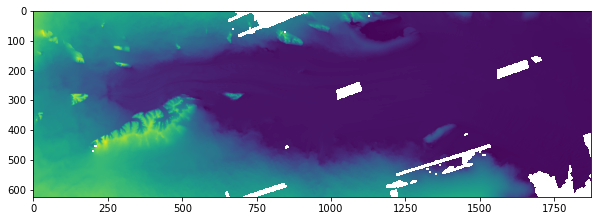

In [61]:
plt.figure(figsize=(10,10))
plt.imshow(fa.surface_values.reshape(dem.shape))

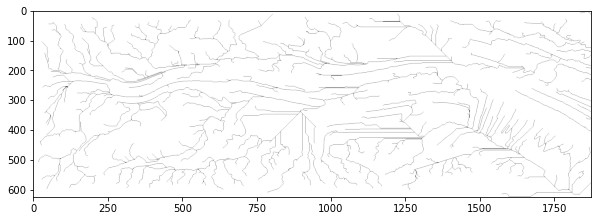

In [60]:
plt.figure(figsize=(10,10))

plt.imshow((fa.node_water_discharge).reshape(dem.shape)>1000, cmap='Greys')